In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install sewar

In [3]:
## Load all the necessary packages

%matplotlib inline

import matplotlib.pyplot as plt
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from skimage.transform import resize
import os
import PIL
import pandas as pd
import imageio
import seaborn as sns
import sewar


from matplotlib.pyplot import imread
import cv2
import h5py

In [4]:
## Load Directory Paths

def load_path(path):
    directories = []
    if os.path.isdir(path):
        print('directory path: ', path)
        directories.append(path)
    for elem in os.listdir(path): #check for nested dir within parent dir
        if os.path.isdir(os.path.join(path,elem)):
            print('inside nested dir')
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    print('directories: ', directories)
    return directories

In [5]:
## Load HR and SR Images from directory

def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    res = {}
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = cv2.imread(os.path.join(d,f))
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
                res[int(os.path.join(d,f)[45:-5])] = image
    
    print('list of files: ',len(files))
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return res

In [6]:
## Load .mat Images from directory

def load_matdata_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = h5py.File(os.path.join(d,f), 'r')
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
                
    
    print('list of files: ',len(files), 'file: ', files[0])
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return files

In [7]:
## Load SR and HR Images

def load_data(directory, ext):
    files = load_data_from_dirs(load_path(directory), ext)
    return files

In [8]:
## Load .mat data files

def load_matdata(directory, ext):
    files = load_matdata_from_dirs(load_path(directory), ext)
    return files

In [9]:
## Load .mat files to get tumor mask

matfiles = load_matdata("../input/mat-images/BrainTumorData/", ".mat")

directory path:  ../input/mat-images/BrainTumorData/
directories:  ['../input/mat-images/BrainTumorData/']
list of files:  3064 file:  <HDF5 file "2912.mat" (mode r)>
list of files path:  3064 file path:  ../input/mat-images/BrainTumorData/2912.mat
Files Read:  3064


In [10]:
## get mask for the images

images_h5 = matfiles[:1000]
tumor_mask = np.array([np.array(img_h5['cjdata']['tumorMask'][()].astype(np.uint32), dtype='object') for img_h5 in images_h5], dtype='object')

In [11]:
# checking for invalid shape images

for idx, img in enumerate(tumor_mask):
    if img.shape != (512,512):
        print(idx, img.shape)

154 (256, 256)
479 (256, 256)
510 (256, 256)
806 (256, 256)
847 (256, 256)
852 (256, 256)


In [12]:
new_tumor_mask = []
for img in tumor_mask:
    if img.shape == (512,512):
        new_tumor_mask.append(img)

In [13]:
## get mask for sr images

img_mask = []
for i in range(600,800):
    img_mask.append(new_tumor_mask[i])

In [14]:
## Load HR Images from the directory
#print(len('../input/escpn-srhr-images/HR_Images/'))
hr_brain_files = load_data("../input/escpn-srhr-images/HR_Images/", ".jpeg")

directory path:  ../input/escpn-srhr-images/HR_Images/
directories:  ['../input/escpn-srhr-images/HR_Images/']
list of files:  200
list of files path:  200 file path:  ../input/escpn-srhr-images/HR_Images/HighRes_170.jpeg
Files Read:  200


In [15]:
from collections import OrderedDict
# sorted(test_list, key = int)
srt_hr_brain_files = OrderedDict(sorted(hr_brain_files.items()))

In [16]:
## Convert each jpeg image to UMat format to apply polygon curve approximation in opencv2

hr_brain_images = []
for i in range(1, len(srt_hr_brain_files)):
    hr_brain_images.append(cv2.cvtColor(cv2.UMat(srt_hr_brain_files[i]), cv2.COLOR_RGB2GRAY))

In [17]:
len(hr_brain_images)

199

In [18]:
## Function to display UMat images

def displayImages(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(img_arr[i].get().astype('f'), cmap='gray')
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

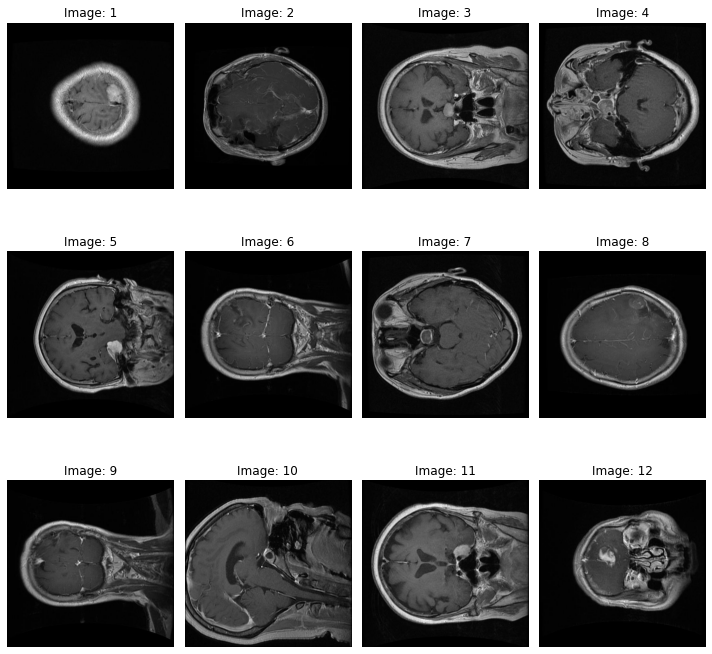

In [19]:
## Visualize few Brain images extracted using binary mask

displayImages(hr_brain_images)

In [20]:
hr_masked_images = [img.get()*mask for img, mask in zip(hr_brain_images, img_mask)]

In [21]:
hr_mask_removed = []
for mask_img, brain_img in zip(hr_masked_images, hr_brain_images):
    hr_mask_removed.append(brain_img.get() - mask_img)

In [22]:
def displayFinalResults(brain_images, tumor_images, final_images, dim=(1, 3), figsize=(15, 5)):
    rows = 3
    cols = 4
    
    for i in range(rows * cols):
        
        fig, axes = plt.subplots(ncols=3, figsize=(10, 3))
        ax = axes.ravel()
        ax[0] = plt.subplot(1, 3, 1)
        ax[1] = plt.subplot(1, 3, 2)
        ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

        ax[0].imshow(brain_images[i].get(), cmap=plt.cm.gray)
        ax[0].set_title('Brain Image after Applying Thresholding')
        ax[0].axis('off')

        ax[1].imshow(np.array(tumor_images[i], dtype='float').squeeze(), cmap=plt.cm.gray)
        ax[1].set_title('Tumor Mask')
        ax[1].axis('off')

        ax[2].imshow(np.array(final_images[i], dtype='float'), cmap=plt.cm.gray)
        ax[2].set_title('Final Image After Removing Mask')
        ax[2].axis('off')

        fig.tight_layout() 
        plt.show()

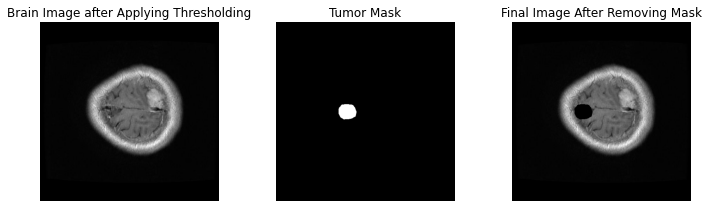

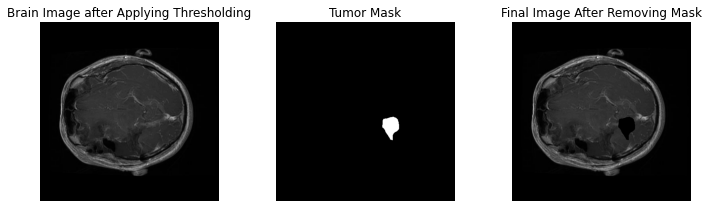

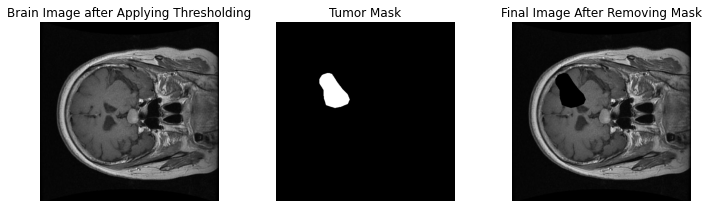

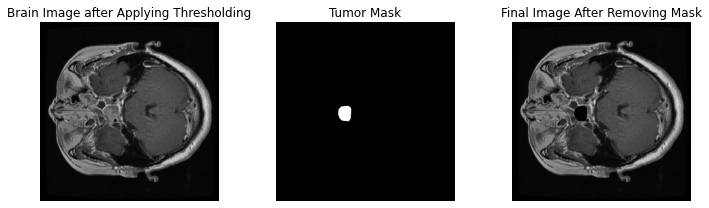

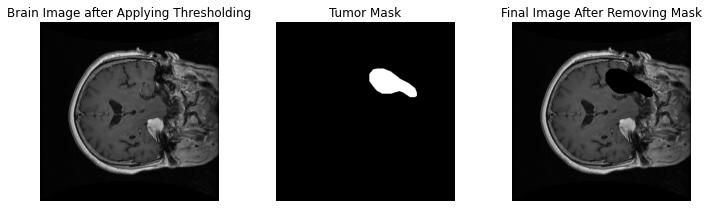

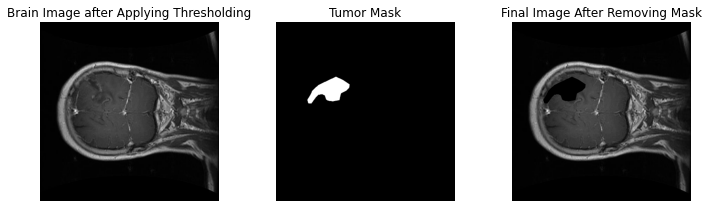

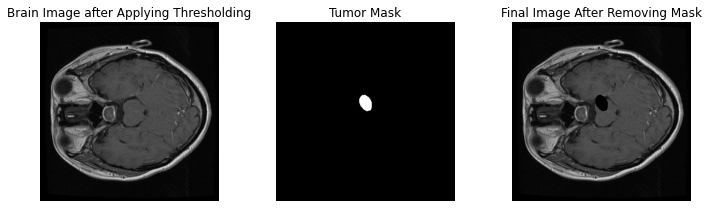

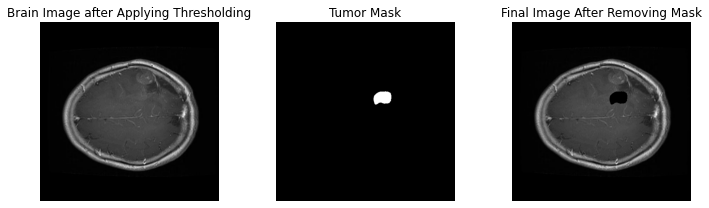

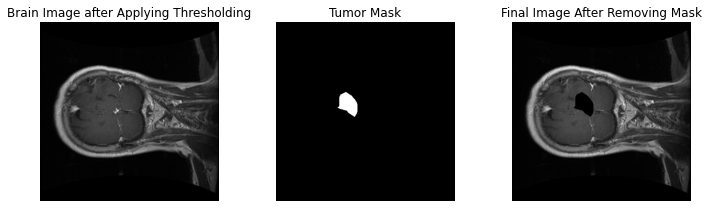

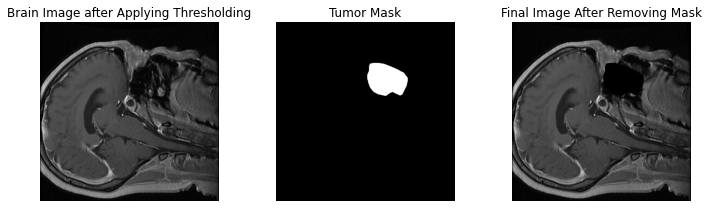

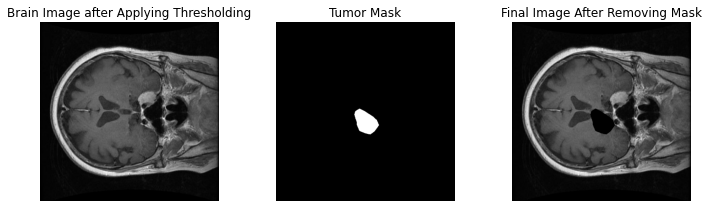

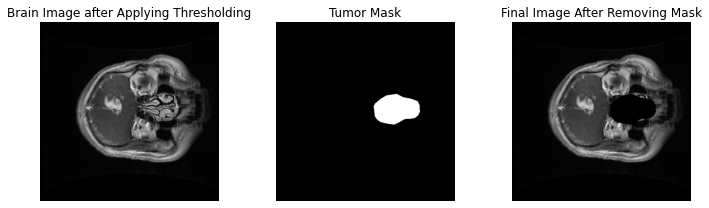

In [23]:
displayFinalResults(hr_brain_images, img_mask, hr_mask_removed)

In [24]:
## Load HR and SR Images from directory

def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    res = {}
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = cv2.imread(os.path.join(d,f))
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
                res[int(os.path.join(d,f)[40:-5])] = image
    
    print('list of files: ',len(files))
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return res

In [25]:
## Load SR Images from the directory

sr_brain_files = load_data("../input/escpn-srhr-images/SR_Images/", ".jpeg")

directory path:  ../input/escpn-srhr-images/SR_Images/
directories:  ['../input/escpn-srhr-images/SR_Images/']
list of files:  200
list of files path:  200 file path:  ../input/escpn-srhr-images/SR_Images/SR_103.jpeg
Files Read:  200


In [26]:
def img_normal(img1, img2):
    hr_img = img1.astype(np.uint16)
    sr_img = img2.astype(np.uint16)
    hr_img = 0.2*hr_img/255.
    sr_img = 0.1*sr_img/255.
    return hr_img, sr_img

In [27]:
from collections import OrderedDict
# sorted(test_list, key = int)
srt_sr_brain_files = OrderedDict(sorted(sr_brain_files.items()))

In [28]:
## Convert each image to UMat in order to apply 

sr_brain_images = []
for i in range(1, len(srt_sr_brain_files)):
    sr_brain_images.append(cv2.cvtColor(cv2.UMat(srt_sr_brain_files[i]), cv2.COLOR_RGB2GRAY))

In [29]:
sr_masked_images = [img.get()*mask for img, mask in zip(sr_brain_images, img_mask)]

In [30]:
sr_mask_removed = []
for mask_img, brain_img in zip(sr_masked_images, sr_brain_images):
    sr_mask_removed.append(brain_img.get() - mask_img)

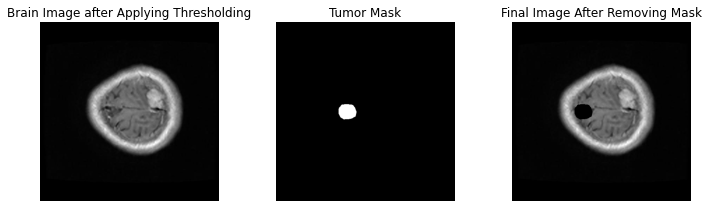

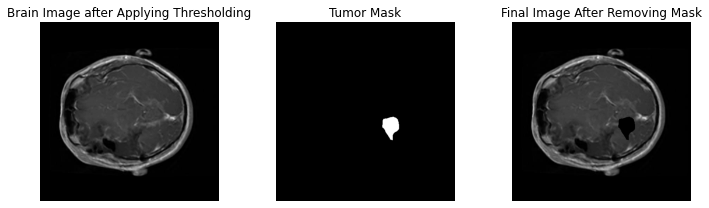

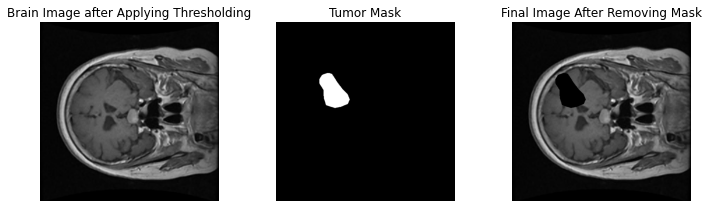

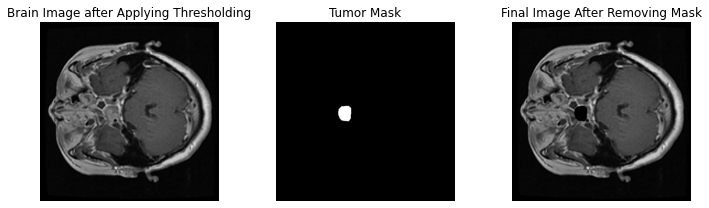

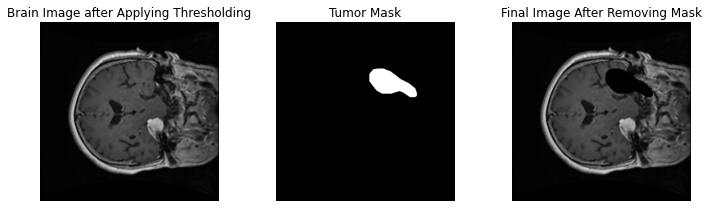

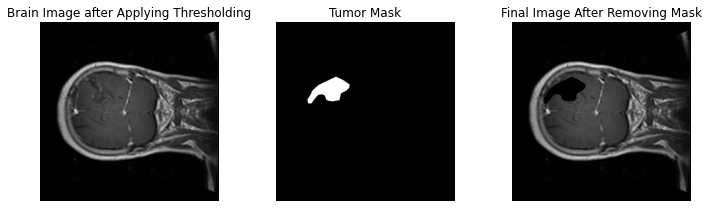

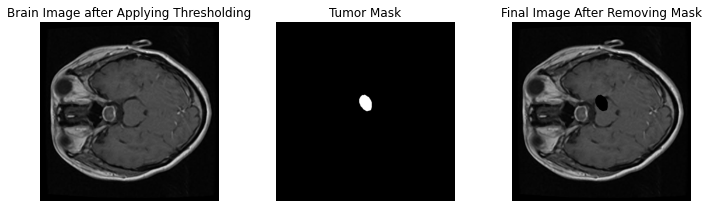

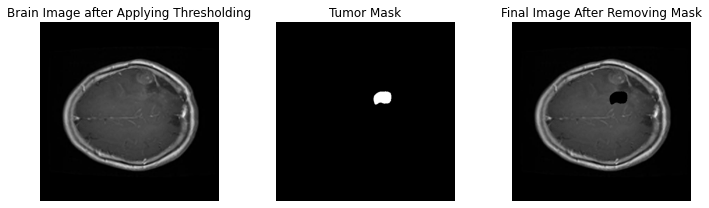

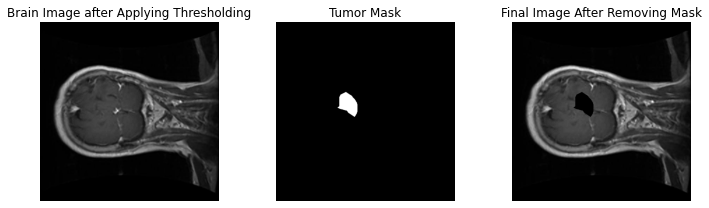

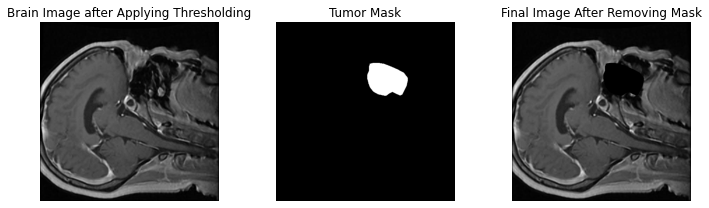

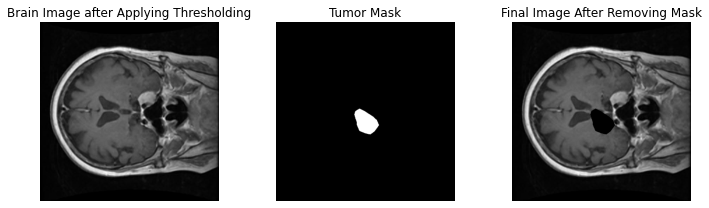

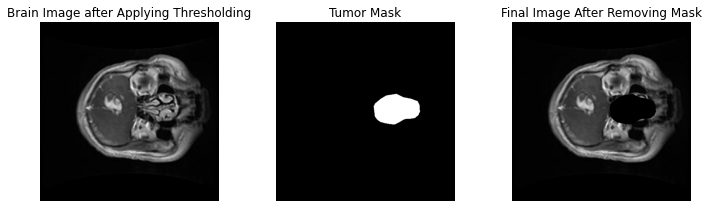

In [31]:
displayFinalResults(sr_brain_images, img_mask, sr_mask_removed)

In [32]:
espcn_brain_metric = {}
espcn_brain_metric["brain"] = {}
espcn_brain_metric["mannwhitneyu"] = {}

## Defining Constants C1 and C2 and C3

### C1 = (K1,L)
### C2 = (K2,L)
### C3 = C2/2

## L is the dynamic range for pixel values [How to decide Value of L?](https://scikit-image.org/docs/dev/user_guide/data_types.html)

**Here K1 and K2 are constant values very very close to 0** 

In [33]:
C1 = (0.01 * 65535) ** 2 
C2 = (0.03 * 65535) ** 2
C3 = C2/2

In [34]:
def luminance(img1, img2):
    mu1 = img1.mean()
    mu2 = img2.mean()
    mu1_sqr = mu1 ** 2
    mu2_sqr = mu2 ** 2
    L = (2*mu1*mu2 + C1) / (2*(mu1_sqr + mu2_sqr) + C1)
    return L

In [35]:
def contrast(img1, img2):
    sigma1 = img1.std()
    sigma2 = img2.std()
    sigma1_sqr = sigma1 ** 2
    sigma2_sqr = sigma2 ** 2
    C = (2*sigma1*sigma2 + C2) / (2*(sigma1_sqr + sigma2_sqr) + C2)
    return C

In [36]:
def structure(img1, img2):
    C3 = C2/2
    sigma1 = img1.std()
    sigma2 = img2.std()
    sigma12 = np.cov(img1, img2)[0,1]
    S = (sigma12 + C3) / (2*sigma1*sigma2 + C3) 
    return S

In [37]:
def compute_ssim(sr_img, hr_img):
    
    sr_img = sr_img.astype(np.uint16)
    hr_img = hr_img.astype(np.uint16)
    
    img1 = np.array(list(filter(lambda pixel : pixel !=0, sr_img.flatten())))
    img2 = np.array(list(filter(lambda pixel : pixel !=0, hr_img.flatten())))
    
    ## Computing Luminance Comparison Function
    
    L = luminance(img1, img2)
    
    ## Computing Contrast Comparison Function
    
    C = contrast(img1, img2)
    
    ## Computing Structure Comparison Function
    
    S = structure(img1, img2)
    
    ## defining alpha, beta, gamma
    
    alpha, beta, gamma = 1, 1, 1

    ssim = (L ** alpha) * (C ** beta) * (S ** gamma)
    
    return ssim

In [38]:
from skimage.metrics import structural_similarity as ssim

In [39]:
## Compute SSIM for single image

ssim(sr_mask_removed[22].astype(np.uint16),hr_mask_removed[22].astype(np.uint16))

0.9999936893724377

In [40]:
ssim_arr = []
for sr_img, hr_img in zip(sr_mask_removed,hr_mask_removed):
    ssim_arr.append(ssim(sr_img.astype(np.uint16), hr_img.astype(np.uint16)))
    
## Display Results for starting 10 images

print(ssim_arr[:10])

[0.9999938049137984, 0.9999932426779551, 0.9999837029334299, 0.9999859387885369, 0.9999893274450646, 0.9999917472849837, 0.9999882720861188, 0.9999939229254335, 0.9999934347246792, 0.9999871754593612]


In [41]:
ssim_mean, ssim_std = np.mean(ssim_arr), np.std(ssim_arr)
espcn_brain_metric["brain"]["ssim"] = ssim_arr
print("mean: ", ssim_mean, " std: ", ssim_std)

mean:  0.9999901516631355  std:  2.9888737289366853e-06


## Universal Quality Index (UQI)

### It is special case of SSIM when C1=0 and C2=0

**NOTE: It produces unstable results when either (mu1_srq + mu2_srq) or (sigma1_sqr + sigma2_sqr) is close to 0**

In [ ]:
# def displayResults(img_arr1, img_arr2,ssim_arr, metric, dim=(1, 3), figsize=(15, 5)):    
#     width=8
#     height=8
#     rows = 5
#     cols = 5
#     axes=[]

#     fig=plt.figure(figsize=(10,10))

#     for i in range(rows * cols):
#         plt.figure(figsize=figsize)

#         plt.subplot(dim[0], dim[1], 1)
#         plt.imshow(np.array(img_arr1[i], dtype='float').squeeze(), interpolation='nearest', cmap='gray')
#         plt.title(f"Super Resolution Image Tumor {i+1}")
#         plt.axis('off')

#         plt.subplot(dim[0], dim[1], 2)
#         plt.imshow(np.array(img_arr2[i], dtype='float').squeeze(), interpolation='nearest', cmap='gray')
#         plt.title(f"Origial Image Tumor {i+1}")
#         plt.axis('off')
        
#         plt.subplot(dim[0], dim[1], 3)
#         plt.text(0.5, 0.5,f"{metric} {ssim_arr[i]}")
#         plt.axis('off')
        
#     fig.tight_layout()    
#     plt.show()

## Display SSIM Results for starting 10 Images

In [ ]:
# displayResults(sr_mask_removed, hr_mask_removed, ssim_arr, "SSIM")

## Mean Absolute Error

In [42]:
from sklearn.metrics import mean_absolute_error as mae

In [43]:
def MAE(true_img, pred_img):
    
    hr_img, sr_img = img_normal(true_img, pred_img)
    
    img1 = np.array(list(filter(lambda pixel : pixel !=0, sr_img.flatten())))
    img2 = np.array(list(filter(lambda pixel : pixel !=0, hr_img.flatten())))
    metric = (np.sum(np.absolute(np.subtract(img1, img2)))) / len(img1)
    return metric

In [44]:
mae(hr_mask_removed[0], sr_mask_removed[0])

1.6308708190917969

In [45]:
mae_arr=[]
for img1, img2 in zip(hr_mask_removed, sr_mask_removed):
    mae_arr.append(mae(img1, img2))
mae_arr = np.array(mae_arr)/10000
print(mae_arr[:10])

[0.00016309 0.00017913 0.00035891 0.0003371  0.00026139 0.0002093
 0.00030207 0.00016285 0.00019651 0.00034145]


In [46]:
mae_mean, mae_std = np.mean(mae_arr), np.std(mae_arr)
espcn_brain_metric["brain"]["mae"] = mae_arr
print("mean: ", mae_mean, " std: ", mae_std)

mean:  0.0002531611610297582  std:  6.32445062147488e-05


## Mean Percentage Error

In [47]:
# from sklearn.metrics import mean_absolute_percentage_error as mape

In [48]:
# def MPE(true_img, pred_img):
    
#     hr_img, sr_img = img_normal(true_img, pred_img)
    
#     img1 = np.array(list(filter(lambda pixel : pixel !=0, hr_img.flatten())))
#     img2 = np.array(list(filter(lambda pixel : pixel !=0., sr_img.flatten())))
#     metric = np.sum((img1 - img2)) / len(img1)
#     return metric * 100

In [49]:
# mape(hr_mask_removed[0], sr_mask_removed[0])

In [50]:
# mpe_arr=[]
# for img1, img2 in zip(hr_mask_removed, sr_mask_removed):
#     mpe_arr.append(MPE(img1, img2))
# print(mpe_arr)
mpe_arr = []
for val in mae_arr:
    mpe_arr.append(val*100)
    
print(mpe_arr[:10])

[0.016308708190917967, 0.01791278839111328, 0.03589118957519531, 0.03371040344238281, 0.026138916015625003, 0.02093040466308594, 0.03020679473876953, 0.016285171508789064, 0.019651184082031252, 0.03414478302001953]


In [51]:
mpe_mean, mpe_std = np.mean(mpe_arr), np.std(mpe_arr)
espcn_brain_metric["brain"]["mpe"] = mpe_arr
print("mean: ", mpe_mean, " std: ", mpe_std)

mean:  0.025316116102975815  std:  0.00632445062147488


### Mean Square Error (MSE)

In [52]:
ans = sewar.full_ref.mse(hr_mask_removed[3], sr_mask_removed[3])
print(ans, type(ans))

33.16844940185547 <class 'numpy.float64'>


In [53]:
mse_arr = []
for i in range(199):
    mse_arr.append(sewar.full_ref.mse(hr_mask_removed[i], sr_mask_removed[i]))
    
## Display Results for starting 10 images

print(mse_arr[:10])

[11.678348541259766, 16.599613189697266, 39.129058837890625, 33.16844940185547, 24.446609497070312, 17.954986572265625, 25.67611312866211, 11.503082275390625, 13.269432067871094, 29.15572738647461]


In [54]:
mse_mean, mse_std = np.mean(mse_arr), np.std(mse_arr)
espcn_brain_metric["brain"]["mse"] = mse_arr
print("mean: ", mse_mean, " std: ", mse_std)

mean:  21.518216923852663  std:  8.123663771813629


### Root Mean Square Error (RMSE)

In [55]:
ans = sewar.full_ref.rmse(hr_mask_removed[10], sr_mask_removed[10])
print(ans, type(ans))

5.348295007847529 <class 'numpy.float64'>


In [56]:
rmse_arr = []
for i in range(199):
    rmse_arr.append(sewar.full_ref.rmse(hr_mask_removed[i], sr_mask_removed[i]))
    
## Display Results for starting 10 images

print(rmse_arr[:10])

[3.4173598788040698, 4.074262287788707, 6.255322440761198, 5.759205622466997, 4.944351271609888, 4.237332483091883, 5.067160262776589, 3.3916194178283954, 3.642723166515827, 5.399604373143889]


In [57]:
rmse_mean, rmse_std = np.mean(rmse_arr), np.std(rmse_arr)
espcn_brain_metric["brain"]["rmse"] = rmse_arr
print("mean: ", rmse_mean, " std: ", rmse_std)

mean:  4.557661328268229  std:  0.8636782622371241


### PSNR

In [58]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [59]:
ans = psnr(hr_mask_removed[5].astype(np.uint16), sr_mask_removed[5].astype(np.uint16))
print(ans, type(ans))

83.78761522857778 <class 'numpy.float64'>


In [60]:
psnr_arr = []
for i in range(199):
    psnr_arr.append(psnr(hr_mask_removed[i].astype(np.uint16), sr_mask_removed[i].astype(np.uint16)))
    
## Display Results for starting 10 images
print(psnr_arr[:10])

[85.65565174867757, 84.1284863946257, 80.40447205487891, 81.12221438451728, 82.44727972243355, 83.78761522857778, 82.234173270175, 85.72132381452066, 85.10094272086404, 81.68222726719705]


In [61]:
psnr_mean, psnr_std = np.mean(psnr_arr), np.std(psnr_arr)
espcn_brain_metric["brain"]["psnr"] = psnr_arr
print("mean: ", psnr_mean, " std: ", psnr_std)

mean:  83.31439488099458  std:  1.6844798515958943


## Multi-Scale Structural Similarity Index (MS-SSIM)

In [62]:
ans = sewar.full_ref.msssim(hr_mask_removed[i].astype(np.uint16), sr_mask_removed[i].astype(np.uint16)).real
print(ans, type(ans))

0.9999985926018555 <class 'numpy.float64'>


In [63]:
msssim_arr = []
for i in range(199):
    try:
        msssim_arr.append(sewar.full_ref.msssim(hr_mask_removed[i].astype(np.uint16), sr_mask_removed[i].astype(np.uint16)).real)
    except:
        continue
## Display Results for starting 10 images
print(msssim_arr[:10])

[0.9999985397215597, 0.9999983347034176, 0.9999960386821699, 0.9999964408836437, 0.9999974627124416, 0.9999979874315361, 0.999997214281742, 0.9999985690663135, 0.9999984391141183, 0.9999972492118127]


In [64]:
msssim_mean, msssim_std = np.mean(msssim_arr), np.std(msssim_arr)
espcn_brain_metric["brain"]["msssim"] = msssim_arr
print("mean: ", msssim_mean,  " std: ", msssim_std)

mean:  0.9999976890490156  std:  7.384082591032453e-07


### Spatial Corelation Coefficient (SCC)

In [65]:
ans = sewar.full_ref.scc(hr_mask_removed[3], sr_mask_removed[3])
print(ans, type(ans))

0.346063182654218 <class 'numpy.float64'>


In [66]:
scc_arr = []
for i in range(199):
    scc_arr.append(sewar.full_ref.scc(hr_mask_removed[i], sr_mask_removed[i]))
    
## Display Results for starting 10 images

print(scc_arr[:10])

[0.2699458360799622, 0.21912525740034142, 0.32642097264413394, 0.346063182654218, 0.3282035054058775, 0.2748238279464151, 0.3441792691443798, 0.2136258612052981, 0.2656476902133993, 0.328055589085765]


In [67]:
scc_mean, scc_std = np.mean(scc_arr), np.std(scc_arr)
espcn_brain_metric["brain"]["scc"] = scc_arr
print("mean: ", scc_mean,  " std: ", scc_std)

mean:  0.3058039813232886  std:  0.05063903466526468


### Pixel Based Visual Information Fidelity (vif-p)

In [68]:
ans = sewar.full_ref.vifp(hr_mask_removed[6], sr_mask_removed[6])
print(ans, type(ans))

0.524321657227969 <class 'numpy.float64'>


In [69]:
vifp_arr = []
for i in range(199):
    vifp_arr.append(sewar.full_ref.vifp(hr_mask_removed[i], sr_mask_removed[i]))
    
## Display Results for starting 10 images

print(vifp_arr[:10])

[0.5461978330355631, 0.5231234594832088, 0.5096433785333877, 0.5013777132697249, 0.5472283469120729, 0.5821926223937091, 0.524321657227969, 0.5776503984627276, 0.5881020175445743, 0.5101785342462062]


In [70]:
vifp_mean, vifp_std = np.mean(vifp_arr), np.std(vifp_arr)
espcn_brain_metric["brain"]["vifp"] = vifp_arr
print("mean: ", vifp_mean,  " std: ", vifp_std)

mean:  0.5565304777538176  std:  0.04073292630976553


In [ ]:
# os.mkdir('./brain')

In [ ]:
# os.mkdir('./brain/error_barplot')
# os.mkdir('./brain/scatter')
# os.mkdir('./brain/regression')

In [ ]:
# ## Define error bar plot function

# def error_barplot(error_arr,title='', file_name=''):
    
#     # Calculate the average
#     error_mean = np.mean(error_arr)
    
#     # Calculate the standard deviation
#     error_std = np.std(error_arr)

#     # Define labels, positions, bar heights and error bar heights
#     labels = ['For 200 Images']
#     x_pos = np.arange(len(labels))
#     CTEs = [error_mean]
#     error = [error_std]
    
#     # Build the plot
#     fig, ax = plt.subplots(figsize=(5,5))
#     ax.bar(x_pos, CTEs,yerr=error,align='center',alpha=0.5,ecolor='black',capsize=10)
# #     ax.set_ylabel('Mean Percentage Error')
#     ax.set_xticks(x_pos)
#     ax.set_xticklabels(labels)
#     ax.set_title(title)
#     ax.yaxis.grid(True)
    
#     plt.savefig(f"./brain/error_barplot/{file_name}.png")

#     # Save the figure and show
#     plt.tight_layout()
#     # plt.savefig('bar_plot_with_error_bars.png')
#     plt.show()

In [ ]:
# error_barplot(mae_arr,title='Mean Absolute Error (MAE)', file_name='mae_barplot')

In [ ]:
# error_barplot(mpe_arr,title='Mean Percentage Error (MPE)', file_name='mpe_barplot')

In [ ]:
# error_barplot(mse_arr,title='Mean Square Error (MSE)', file_name='mse_barplot')

In [ ]:
# error_barplot(rmse_arr,title='Root Mean Square Error (RMSE)', file_name='rmse_barplot')

In [ ]:
# error_barplot(psnr_arr,title='Peak Signal to Noise Ratio (PSNR)', file_name='psnr_barplot')

In [ ]:
# error_barplot(ssim_arr,title='Structural Similarity Index (SSIM)', file_name='ssim_barplot')

In [ ]:
# error_barplot(scc_arr,title='Spatial Corelation Coefficient (SCC)', file_name='scc_barplot')

In [ ]:
# error_barplot(vifp_arr,title='Pixel Based Visual Information Fidelity (vif-p)', file_name='vifp_barplot')

## Scatter Plot for MAE, MPE, MSE, RMSE, PSNR, SSIM, MS-SSIM, SCC and VIF-P

In [ ]:
# import seaborn as sns
# sns.set_theme(style="whitegrid")
# sns.set(rc={'figure.figsize':(8,8)})

In [ ]:
# metric_dict = {'Images': [i for i in range(1,200)],
#             'MAE' : mae_arr,
#             'MPE' : mpe_arr,
#             'MSE' : mse_arr,
#             'RMSE' : rmse_arr,
#             'PSNR' : psnr_arr,
#             'SSIM' : ssim_arr,
#             'SCC' : scc_arr,
#             'VIFP' : vifp_arr
#          }
# metric_df = pd.DataFrame(metric_dict)

In [ ]:
# def getScatterPlot(y_val,df,title='', file_name=''):
    
#     sns_plt = sns.scatterplot(x=metric_df.Images, y=y_val, data=df, linewidth=2.5).set_title(title)
#     sns_fig = sns_plt.get_figure()
#     sns_fig.savefig(f"./brain/scatter/{file_name}.png")

In [ ]:
# def RegPlot(y_val,df,title='', file_name=''):
    
#     sns_plt = sns.regplot(x=metric_df.Images, y=y_val, data=df).set_title(title)
#     sns_fig = sns_plt.get_figure()
#     sns_fig.savefig(f"./brain/regression/{file_name}.png")

In [ ]:
# getScatterPlot(metric_df.MAE, metric_df, 'Mean Absolute Error', 'mae_scatter')

In [ ]:
# getScatterPlot(metric_df.MPE, metric_df, title='Mean Percentage Error', file_name='mpe_scatter')

In [ ]:
# getScatterPlot(metric_df.MSE, metric_df, title='Mean Square Error', file_name='mse_scatter')

In [ ]:
# getScatterPlot(metric_df.RMSE, metric_df, title='Root Mean Square Error', file_name='rmse_scatter')

In [ ]:
# getScatterPlot(metric_df.PSNR, metric_df, title='Peak Signal to Noise Ratio', file_name='psnr_scatter')

In [ ]:
# getScatterPlot(metric_df.SSIM, metric_df, title='Structure Similarity Index', file_name='ssim_scatter')

In [ ]:
# getScatterPlot(metric_df.SCC, metric_df, title='Spatial Corelation Coefficient', file_name='scc_scatter')

In [ ]:
# getScatterPlot(metric_df.VIFP, metric_df, title='Pixel Based Visual Information Fidelity', file_name='vifp_scatter')

## Regression Plot for MAE, MPE, MSE, RMSE, PSNR, SSIM, MS-SSIM, SCC and VIF-P

In [ ]:
# RegPlot(metric_df.MAE, metric_df, 'Mean Absolute Error', 'mae_scatter')

In [ ]:
# RegPlot(metric_df.MPE, metric_df, title='Mean Percentage Error', file_name='mpe_scatter')

In [ ]:
# RegPlot(metric_df.MSE, metric_df, title='Mean Square Error', file_name='mse_scatter')

In [ ]:
# RegPlot(metric_df.RMSE, metric_df, title='Root Mean Square Error', file_name='rmse_scatter')

In [ ]:
# RegPlot(metric_df.PSNR, metric_df, title='Peak Signal to Noise Ratio', file_name='psnr_scatter')

In [ ]:
# RegPlot(metric_df.SSIM, metric_df, title='Structure Similarity Index', file_name='ssim_scatter')

In [ ]:
# RegPlot(metric_df.SCC, metric_df, title='Spatial Corelation Coefficient', file_name='scc_scatter')

In [ ]:
# RegPlot(metric_df.VIFP, metric_df, title='Pixel Based Visual Information Fidelity', file_name='vifp_scatter')

In [75]:
import pickle

with open('./espcn_brain_pickle.pkl', 'wb') as f:
    pickle.dump(espcn_brain_metric, f)

In [76]:
%%!

zip espcn_brain_metric.zip ./espcn_brain_pickle.pkl

['  adding: espcn_brain_pickle.pkl (deflated 55%)']